In [21]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import MySQLdb
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [17]:
conn = MySQLdb.connect(host="localhost", user="root", passwd="", db="iot")
cursor = conn.cursor()
#cursor.execute('select time, source, destination, protocol, type, size from ip limit 250');
#cursor.execute('SELECT time, sum(size) as size FROM ip WHERE time >="2018-03-08 12:38:00" AND time <"2018-03-08 12:48:00" group by time')
cursor.execute('SELECT time, size FROM ip WHERE time >="2018-03-08 12:38:00" AND time <"2018-03-08 12:48:00"')

rows = cursor.fetchall()

cursor.execute('SELECT time, sum(size) as size FROM ip WHERE time >="2018-11-10 7:22:00" AND time <"2018-11-10 7:32:00" group by time')

rows2 = cursor.fetchall()

In [18]:
df = pd.DataFrame( [[ij for ij in i] for i in rows] )
df2 = pd.DataFrame( [[ij for ij in i] for i in rows2] )
df2.rename(columns={0: 'Time', 1: 'Size'}, inplace=True);
df.rename(columns={0: 'Time', 1: 'Size'}, inplace=True)
df['Size'] = pd.to_numeric(df['Size'])
df2['Size'] = pd.to_numeric(df2['Size'])
df.info()
packets_df = df
df = df.groupby(['Time']).sum().reset_index()
df.head()
#df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 2 columns):
Time    4754 non-null datetime64[ns]
Size    4754 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 74.4 KB


,Time,Size
0,2018-03-08 12:38:00,126
1,2018-03-08 12:38:01,1276
2,2018-03-08 12:38:02,1374
3,2018-03-08 12:38:03,690
4,2018-03-08 12:38:05,460


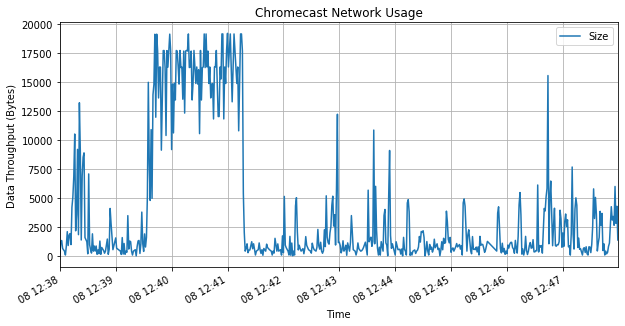

In [19]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()

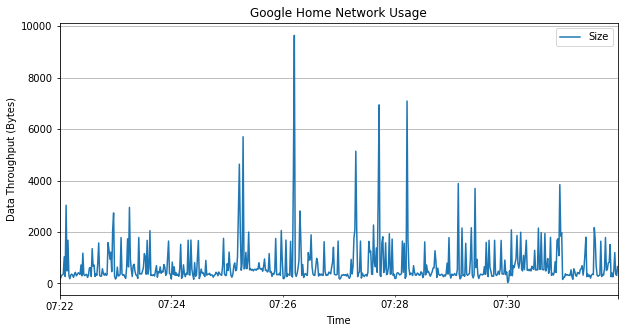

In [20]:
ax = df2.plot(x='Time', y='Size', kind='line', grid=True, title='Google Home Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
plt.show()

In [33]:
def ilp_constant_alg(input_df, constant_rate):
    output_df = pd.DataFrame(columns=['Time', 'Size'])
    stats = {'max_delay' : 0, 'num_packets_delayed' : 0, 'total_padding' : 0, 'num_times_padded' : 0}
    padding = 0
    delayed_time = 0
    current_size = 0
    current_time = 0
    delayed_packets = []
    for index in range(len(input_df)):
        t = input_df['Time'].iloc[index]
        s = input_df['Size'].iloc[index]
        if t != current_time:
            if current_size < constant_rate and current_time != 0:
                padding = constant_rate - current_size
                output_df = output_df.append({'Time': current_time, 'Size': padding}, ignore_index=True)
                stats['total_padding'] += padding
                stats['num_times_padded'] += 1
            current_time = t
            current_size = 0
        pop_count = 0
        for dt, ds in delayed_packets:
            if ds + current_size <= constant_rate:
                current_size += ds
                output_df = output_df.append({'Time': current_time, 'Size': ds}, ignore_index=True)
                delayed_time = (current_time - dt).total_seconds()
                if delayed_time > stats['max_delay']:
                    stats['max_delay'] = delayed_time
                pop_count += 1
            else:
                break
        for i in range(pop_count):
            delayed_packets.pop(0)
        if s + current_size <= constant_rate:
            output_df = output_df.append({'Time': t, 'Size': s}, ignore_index=True)
            current_size += s
        else:
            delayed_packets.append((t,s))
            stats['num_packets_delayed'] += 1
    if current_size < constant_rate and current_time != 0:
            padding = constant_rate - current_size
            output_df = output_df.append({'Time': current_time, 'Size': padding}, ignore_index=True)
            stats['total_padding'] += padding
            stats['num_times_padded'] += 1
    return output_df, stats

In [34]:
ilp_const_df, ilp_const_stats = ilp_constant_alg(packets_df, 12500)
ilp_const_df = ilp_const_df.groupby(['Time']).sum().reset_index()
ilp_const_df.head()

,Time,Size
0,2018-03-08 12:38:00,12500
1,2018-03-08 12:38:01,12500
2,2018-03-08 12:38:02,12500
3,2018-03-08 12:38:03,12500
4,2018-03-08 12:38:05,12500


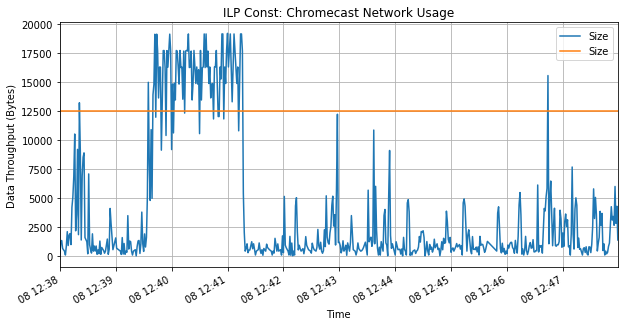

In [35]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
ilp_const_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Const: Chromecast Network Usage', figsize=(10,5), ax=ax)
plt.show()

In [36]:
for stat in ilp_const_stats:
    print("Stats : {} : {}".format(stat,ilp_const_stats[stat]))

Stats : max_delay : 38.0
Stats : num_packets_delayed : 1047
Stats : total_padding : 4612123
Stats : num_times_padded : 555


In [ ]:
#555 total entries
#total_padding / num_times_padded = network overhead

In [22]:
def ilp_variable_alg(input_df, min_rate, max_rate):
    output_df = pd.DataFrame(columns=['Time', 'Size'])
    stats = {'max_delay' : 0, 'num_packets_delayed' : 0, 'total_padding' : 0, 'num_times_padded' : 0}
    padding = 0
    delayed_time = 0
    current_size = 0
    current_time = 0
    delayed_packets = []
    current_rate = 0
    for index in range(len(input_df)):
        t = input_df['Time'].iloc[index]
        s = input_df['Size'].iloc[index]
        if t != current_time:
            if current_size < current_rate and current_time != 0:
                padding = current_rate - current_size
                output_df = output_df.append({'Time': current_time, 'Size': padding}, ignore_index=True)
                stats['total_padding'] += padding
                stats['num_times_padded'] += 1
            current_time = t
            current_size = 0
            current_rate = random.randint(min_rate, max_rate)
        pop_count = 0
        for dt, ds in delayed_packets:
            if ds + current_size <= current_rate:
                current_size += ds
                output_df = output_df.append({'Time': current_time, 'Size': ds}, ignore_index=True)
                delayed_time = (current_time - dt).total_seconds()
                if delayed_time > stats['max_delay']:
                    stats['max_delay'] = delayed_time
                pop_count += 1
            else:
                break
        for i in range(pop_count):
            delayed_packets.pop(0)
        if s + current_size <= current_rate:
            output_df = output_df.append({'Time': t, 'Size': s}, ignore_index=True)
            current_size += s
        else:
            delayed_packets.append((t,s))
            stats['num_packets_delayed'] += 1
    if current_size < current_rate and current_time != 0:
            padding = current_rate - current_size
            output_df = output_df.append({'Time': current_time, 'Size': padding}, ignore_index=True)
            stats['total_padding'] += padding
            stats['num_times_padded'] += 1
    return output_df, stats

In [23]:
ilp_var_df, ilp_var_stats = ilp_variable_alg(packets_df, 10000, 15000)
ilp_var_df = ilp_var_df.groupby(['Time']).sum().reset_index()
ilp_var_df.head()

,Time,Size
0,2018-03-08 12:38:00,10813
1,2018-03-08 12:38:01,10887
2,2018-03-08 12:38:02,13864
3,2018-03-08 12:38:03,10006
4,2018-03-08 12:38:05,11084


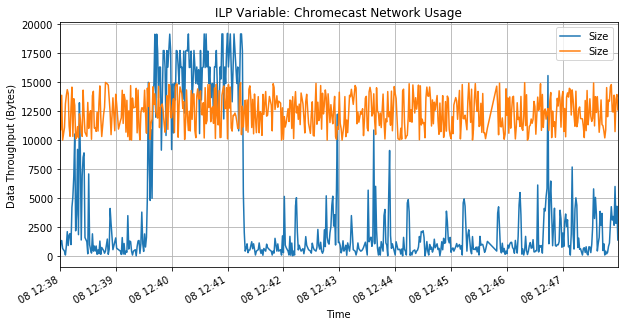

In [26]:
ax = df.plot(x='Time', y='Size', kind='line', grid=True, title='Chromecast Network Usage', figsize=(10,5))
ax.set_xlabel('Time')
ax.set_ylabel('Data Throughput (Bytes)')
ilp_var_df.plot(x='Time', y='Size', kind='line', grid=True, title='ILP Variable: Chromecast Network Usage', figsize=(10,5), ax=ax)
plt.show()

In [25]:
for stat in ilp_var_stats:
    print("Stats : {} : {}".format(stat,ilp_var_stats[stat]))

Stats : max_delay : 36.0
Stats : num_packets_delayed : 1108
Stats : total_padding : 4561571
Stats : num_times_padded : 555
